# Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation

Розклад невід'ємних матриць це група алгоритмів багатовимірного аналізу та лінійної алгебри, де матриця V розкладається в, зазвичай, дві матриці W, H, враховуючи, що жодна з трьох матриць немає від'ємних елементів. Завдяки невід'ємності результуючі матриці легко перевіряються. Крім того, в таких програмах, як обробка аудіо спектрограм даним притаманна ця невід'ємність. Так як проблема немає точних розв'язків, в загальному випадку, зазвичай, знаходять числове наближення.

У цій статті описано, як:
* Підготувати текст до визначення теми
* Визначити теми статей
* Описати ці теми
* Автоматично визначити найкращу кількість тем
* Знайти найякісніші теми серед усіх тем
* Спрогнозувати тему нової статті

Використані джерела:
* Towards Data Science: [Topic Modeling Articles with NMF](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)
* GitHub: [personal_data_science_projects/topic_modeling_nmf/](https://github.com/robsalgado/personal_data_science_projects/tree/master/topic_modeling_nmf)
* Wiki: [Non-negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)


# Python пакети

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Run the utilty functions from the seperate notebook
%run nmf_utils.ipynb

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


# Завантажити дані

У цьому прикладі використовується набір даних статей, взятих з роздулу «Бізнес» веб-сайту CNN за період з кінця березня 2020 року до початку квітня 2020 року. Статті на сторінці «Бізнес» зосереджені на кількох різних темах, включаючи інвестування, банківську справу, відеоігри, технології, ринки тощо. Всього зібрано 301 статтю із середньою кількістю слів 732 і стандартним відхиленням 363 слова. Ось перші п'ять рядків:

In [3]:
file_path = '../data/original/cnn_data_4_5.csv'
df = pd.read_csv(file_path)

print(df.shape)
df.head()

(301, 4)


url  \
0  https://www.cnn.com/2020/03/23/media/japan-abe...   
1  https://www.cnn.com/2020/03/16/perspectives/us...   
2  https://www.cnn.com/2020/03/23/investing/globa...   
3  https://www.cnn.com/2020/03/24/economy/china-e...   
4  https://www.cnn.com/2020/03/24/business/bailou...   

                                               title  \
0  Japan asked the international media to change ...   
1      The United States is still too reliant on oil   
2  Global stocks and US futures rise as policymak...   
3  China is trying to revive its economy without ...   
4  Companies that binged on buybacks now seek bai...   

                                                body       date  
0  In the new system "Canton becomes Guangzhou an...  3/24/2020  
1  Saudi Arabia's decision to open its taps comes...  3/24/2020  
2  The promise of unlimited support for markets f...  3/24/2020  
3  The country where the pandemic began was almos...  3/24/2020  
4  Now, some of the same companies that binged on...  3/24/2020

In [9]:
# Get the word count
df['word_count'] = df['body'].apply(word_count)
# Descriptive statistics for word count
df['word_count'].describe()

count     301.000000
mean      731.857143
std       363.381310
min        93.000000
25%       473.000000
50%       682.000000
75%       966.000000
max      2502.000000
Name: word_count, dtype: float64

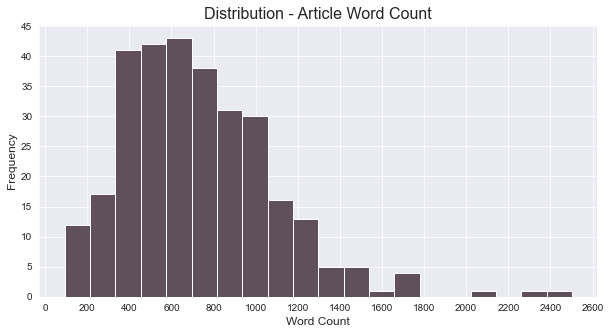

In [10]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 50, 5))
plt.xticks(np.arange(0, 2700, 200))

# file_name = 'hist'
# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

In [11]:
df['word_count'].values

array([1075,  623,  547, 1483, 1176,  385, 1093,  398,  339,  837,  724,
       1053,  616,  571,  713,  496,  555,  600,  642,  949,  480,  196,
        647,  717,  515, 1214,  224,  468,  185,  760,  685,  578,  792,
       1209,  640, 1029,  656,  503,  386,  622,  419,  596,  505,  914,
       1037,  894, 1064,  311,  258,  834, 1665,  600, 1037,  338, 1680,
        182,  628, 1168,  582,  734,  515,  720, 1193,  380, 1057,  273,
        468,  188,  496,  829,  493,  689,  783,  481,  327,  499,  993,
       1040,  585, 1210,  385,  971,  484, 2039,  459,  609, 1015,  785,
       1048,  465,  213,  522,  365,  678,  332,  758,  536, 1109, 1207,
        701,  642,  972,  867,  987,  683, 1110,  862,  722, 1770,  186,
       1109,  852, 1552,  480,  920,  351,  753,  420,  631,  698,  353,
       1125,  342,  726, 1004, 1123,  207,  429,  192,  357, 1304,  344,
        559,  398, 1203,  363,  887,  402,  634,  405, 1387,  843,  385,
        833,  499,  839,  587,  623,  889,  610,  3

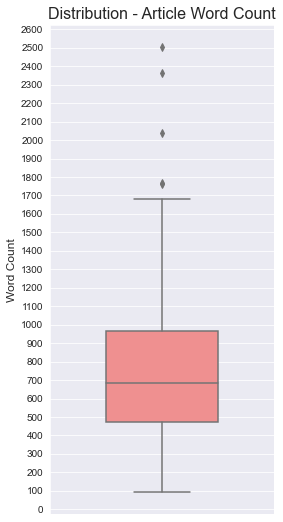

In [12]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4, 9))

sns.boxplot(
    data=df, 
    y='word_count',
    orient='vertical',
    width=.5,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
plt.yticks(np.arange(0, 2700, 100))

# file_name = 'box_plot'
# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

Поглянемо на розподілу кількості слів. Він трохи позитивно скошений, але в цілому це досить нормальний розподіл з 25-м процентилем на відмітці 473 слова і 75-м процентилем з відмітці 966 слів. Маємо 4 викиди (в 1,5 рази вище 75-го процентиля), найдовша стаття має 2,5 тисячі слів.

Давайте поглянемо на 20 найпопулярніших серед усіх статей після обробки тексту.

In [13]:
# Process the text
df['processed_text'] = df['body'].apply(process_text)
df.head()

url  \
0  https://www.cnn.com/2020/03/23/media/japan-abe...   
1  https://www.cnn.com/2020/03/16/perspectives/us...   
2  https://www.cnn.com/2020/03/23/investing/globa...   
3  https://www.cnn.com/2020/03/24/economy/china-e...   
4  https://www.cnn.com/2020/03/24/business/bailou...   

                                               title  \
0  Japan asked the international media to change ...   
1      The United States is still too reliant on oil   
2  Global stocks and US futures rise as policymak...   
3  China is trying to revive its economy without ...   
4  Companies that binged on buybacks now seek bai...   

                                                body       date  word_count  \
0  In the new system "Canton becomes Guangzhou an...  3/24/2020        1075   
1  Saudi Arabia's decision to open its taps comes...  3/24/2020         623   
2  The promise of unlimited support for markets f...  3/24/2020         547   
3  The country where the pandemic began was almos...  3/24/2020        1483   
4  Now, some of the same companies that binged on...  3/24/2020        1176   

                                      processed_text  
0  [new, canton, becom, guangzhou, tientsin, beco...  
1  [saudi, arabia, decis, open, tap, come, talk, ...  
2  [promis, unlimit, support, market, feder, rese...  
3  [countri, pandem, began, complet, shut, late, ...  
4  [compani, bing, buyback, line, receiv, taxpaye...

In [14]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

word  frequency
0       compani        972
1          busi        750
2         peopl        718
3          work        693
4   coronavirus        564
5          week        542
6        worker        536
7          time        508
8          year        495
9           new        480
10         need        440
11      employe        422
12         make        417
13       govern        383
14        state        371
15         home        367
16         help        360
17          day        345
18       market        339
19         mani        336

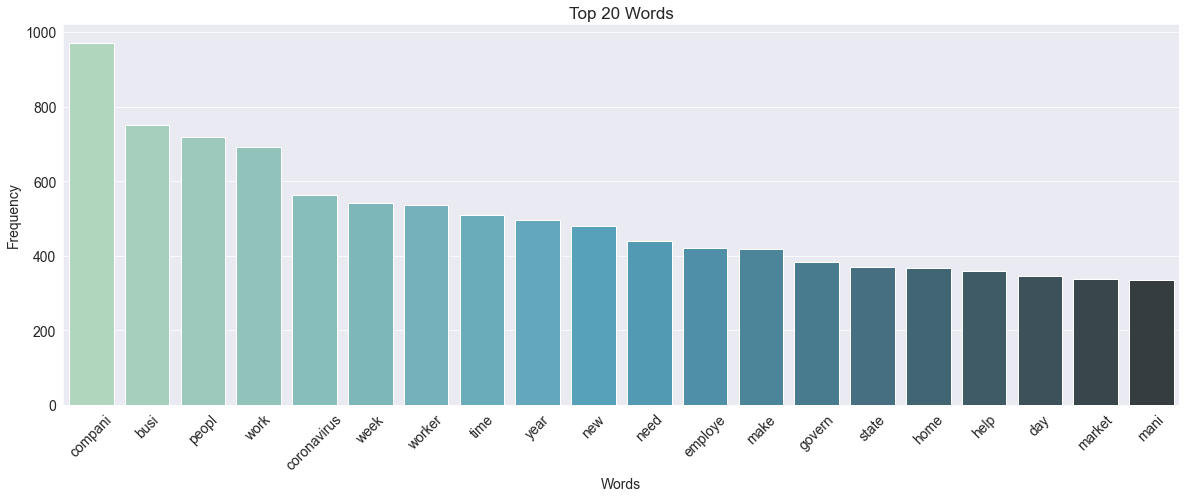

In [15]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

file_name = 'top_words'

# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

«Company», «business», «people», «work» та «coronavirus» - це топ-5 слів, що має сенс, враховуючи фокус сторінки та часовий проміжок, коли дані були зібрані.

# NMF

Розклад невід’ємної матриці (NMF) — це методика машиного навчання без вчителя, тому немає маркування тем, за якими буде навчатися модель. Принцип роботи полягає в тому, що NMF розкладає вектори високої розмірності в представлення низької розмірності. 

Використовуючи вихідну матрицю (A), яка є оригінальними текстами, NMF дасть вам дві матриці (W і H). W — слова, які репрезентуєть знайдені теми, а H — коефіцієнти (ваги), які визначають до якої теми належить текст.

Отже, припустивши 301 статтю, 5000 слів і 30 тем, ми отримаємо такі 3 матриці:

In [16]:
texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=30,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [17]:
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

In [18]:
print(A.shape)
print(W.shape)
print(H.shape)

(301, 5000)
(30, 5000)
(301, 30)


NMF буде змінювати початкові значення W і H так, щоб добуток наближався до A, доки не мінімізую похибку або не буде досягнуто максимальну кількість ітерацій.

У нашому випадку багатовимірні вектори будуть вагами tf-idf, але це може бути будь-що, включаючи вектори слів або простий підрахунок слів.

# Обробка тексту

Працюючи з текстом, дуже важливо зменшити кількість унікальних слів, оскільки їх буде багато.
Крім того, збираючи дані з сайтів необхідно перевірити текст та переконатися, що немає помилкових символів HTML чи переносу на новий рядок. 

Нижче наведені функції, які зроблять необхідну перевірку:
* токенізація тексту
* приведення тексту до нижнього регістру
* приведення скорочень до повного написання
* стемінг токенів
* видаляє розділові знаки, стоп-слова, цифри, окремі символи та слова з зайвими пробілами (артефакт від розгортання скорочень)

In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

Це типова функція для обробки тексту. Проте кожен корпус текстів унікальний, тож може знадобитись адаптувати цю функцію до вашого корпусу. Наприклад, можна додати спеціальні стоп-слова, які часто з’являються у ваших текстах і, швидше за все, не покращують здатність моделі інтерпретувати теми.

Ось приклад тексту до та після обробки:

In [34]:
df.loc[0, 'body'][:123]

'In the new system "Canton becomes Guangzhou and Tientsin becomes Tianjin." Most importantly, the newspaper would now refer '

In [35]:
process_text(df.loc[0, 'body'])[:10]

['new',
 'canton',
 'becom',
 'guangzhou',
 'tientsin',
 'becom',
 'tianjin',
 'import',
 'newspap',
 'refer']

# Створення нових ознак, вибір ознак та скорочення їх кількості

Після підготовки тексту нам необхідно певним чином закодувати, виразити його у числовому форматі. Є кілька різних способів зробити це. Загалом способ трансформації тексту в числа підбирається під кожну задачу, корпус тексту та модель. В даному випадку достатньо ефективним і швидким є обчислення вагів tf-idf.

Ви можете прочитати більше про [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) тут. Крім того ви можете спробувати такі техніки як [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) та [word vectors](https://en.wikipedia.org/wiki/Word2vec).

Для вибору функції ми встановимо «min_df» на 3, що вкаже моделі ігнорувати слова, які зустрічаються менше ніж у 3 статтях. Крім того, ми встановимо «max_df» як .85, що скаже моделі ігнорувати слова, які зустрічаються в більш ніж 85% статей. Це допоможе нам виключити слова, які не впливають на модель. Загалом ці та інші гіперпараметри моделей трансформації та моделювання тем можуть підбиратися експериментально або різноманітними методами [оптимізації гіперпараметрів](https://uk.wikipedia.org/wiki/%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D1%96%D0%B7%D0%B0%D1%86%D1%96%D1%8F_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2#%D0%9F%D0%BE%D1%88%D1%83%D0%BA_%D0%BF%D0%BE_%D2%91%D1%80%D0%B0%D1%82%D1%86%D1%96) моделі.

Після обробки ми маємо трохи більше 9 тис. унікальних слів, тому ми налаштуємо max_features, щоб залишити лише 5 тис. найпопулярніших (найчастіших) елементів у статтях для подальшого зменшення кількості функцій.

Ваги tf-idf обчислюються не лише для окремих слів, але і для [n-грам](https://en.wikipedia.org/wiki/N-gram) (біграми, триграми тощо). Для цього ми встановимо діапазон n_gram на (1,  2), який включатиме уніграми та біграми.

Нам також потрібно використовувати препроцесор для приєднання токенізованих слів, оскільки модель буде токенізувати все за замовчуванням.

In [36]:
texts = df['processed_text']

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

Тепер, коли у нас є числове представлення для кожної статті, ми можемо створити модель визначення тем.

# Ручне тематичне моделювання

Спочатку розглянемо приклад тематичного моделювання, де ми вручну вибираємо кількість тем. Після розглянемо, як автоматично вибирати найкращу кількість тем. 

In [38]:
nmf = NMF(
    n_components=20,
    init='nndsvd'
).fit(tfidf)

Наразі ми просто встановимо кількість компонентів (тем) 20, а пізніше ми будемо використовувати показник когерентності, щоб автоматично вибирати найкращу кількість тем.

Я також ініціалізую модель методом «nndsvd» (Nonnegative Double Singular Value Decomposition), що найкраще працює на розріджених даних, як у нас тут. Решту гіперпараметрів залишимо за замовчуванням, які добре працюють. Однак сміливо експериментуйте з [різними параметрами](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

# Оцінка когерентності

Щоб оцінити найкращу кількість тем, ми можемо використовувати оцінку когерентності. Пояснення того, як він обчислюється, виходить за рамки цієї статті, але загалом він вимірює відносну відстань між словами в темі. [Ось](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) оригінальна стаття про те, як це реалізовано в gensim.

Існує кілька різних типів оцінки когерентності, двома найпопулярнішими є c_v та u_mass. c_v точніший, тоді як u_mass швидше. Я буду використовувати тут c_v, який коливається від 0 до 1, при цьому 1 - це абсолютно виразні темами.

Мені подобається реалізація NMF у sklearn, тому що вона може використовувати коефіцієнти tf-idf, які, в даному випадку, працюють краще, ніж просто частота слів, яку може використовувати реалізація gensim. Однак реалізація NMF у sklearn не має оцінку когерентності, і я не зміг знайти приклад того, як обчислити його вручну за допомогою c_v (є [один](https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb), який використовує TC-W2V). TODO пошукати приклад.

Тому ми будемо використовувати gensim, щоб обчислити оцінку когерентності та отримати найкращу кількість тем, а потім використаємо цю кількість тем з реалізацією NMF від sklearn.

# Автоматичний вибір найкращої кількості тем

Очевидно, що наявність способу автоматичного вибору найкращої кількості тем є досить зручною, особливо для використання моделі у виробництві. Використовуючи оцінку когерентності, ми можемо оцінити моделі для різної кількості тем і обрати ту, яка матиме найбільшу оцінку когерентності. Це, звичайно, не ідеально, але загалом працює досить добре.

In [39]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

30


Для кількості тем, які потрібно спробувати, я вибрав діапазон від 5 до 75 з кроком 5. Після запуску моделі ми можемо візуально перевірити оцінку когерентності.

In [41]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

# file_name = 'c_score'

# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

In [46]:
max(coherence_scores)

0.4345

In [49]:
sorted(coherence_scores)[-2]

0.43246

30 — це кількість тем, яка отримала найвищий бал когерентності (0,435), і після цього вона досить швидко спадає. Загалом це пристойний показник, але не варто покладатись лише на цю оцінку. Справжня перевірка полягає в тому, щоб самостійно переглядати теми, щоб переконатися, що вони мають сенс для статей.

Кількість тем 10 займала друге місце з оцінкою .432, тож цей варіант також можна було вибрати. Загалом, з графіка досить очевидно, що теми від 10 до 40 дадуть хороші результати. Зараз ми розглянемо 30.

In [50]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

# Опис тем

Одне з рішень — це, щоб людина переглядала тексти та вручну описала їх теми. Інший варіант — використовувати слова в кожній темі, які отримали найвищий бал для цієї теми, і зіставити їх із назвами фіч. Давайте поглянемо на 8 найкращих слів:

In [51]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

0        1          2             3         4         5           6  \
0    work     home  work home         offic       kid      desk       peopl   
1     oil    saudi      price  saudi arabia    arabia    russia      barrel   
2   china  economi     econom     economist   quarter      bank     countri   
3   trump      fox       news         brief  fox news   hanniti  white hous   
4  airlin   flight    passeng       carrier       fli  industri      travel   

         7                                             topics  
0   school              work home offic kid desk peopl school  
1     opec          oil saudi price arabia russia barrel opec  
2      gdp  china economi econom economist quarter bank co...  
3   presid     trump fox news brief hanniti white hous presid  
4  billion  airlin flight passeng carrier fli industri tra...

Ми можемо зіставити ці теми зі статтями за індексом.

In [59]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

# topic_df.head()
topic_df["topics"].values

array(['work home offic kid desk peopl school',
       'oil saudi price arabia russia barrel opec',
       'china economi econom economist quarter bank countri gdp',
       'trump fox news brief hanniti white hous presid',
       'airlin flight passeng carrier fli industri travel billion',
       'stream internet servic network video livestream live',
       'beer sale breweri alcohol nielsen march brand craft',
       'film disney theater movi releas studio mulan theatric',
       'ventil ford devic patient product design ge produc',
       'instacart worker shopper custom order gig compani',
       'unemploy job week rate report claim economist',
       'amazon facil worker employe warehous compani small temperatur',
       'store walmart employe retail groceri open custom',
       'women men gender gap pay equal make job',
       'furlough employe compani disney salari park worker',
       'small busi loan sba owner payrol lender',
       'market cac dax gain futur stock kospi dow',

In [53]:
# Creating a temp df with the url and topic num to join on
url = df['url'].tolist()

df_temp = pd.DataFrame({
    'url': url,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='url',
    how='left'
)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)

df_topics.head()

url  \
0  https://www.cnn.com/2020/03/23/media/japan-abe...   
1  https://www.cnn.com/2020/03/16/perspectives/us...   
2  https://www.cnn.com/2020/03/23/investing/globa...   
3  https://www.cnn.com/2020/03/24/economy/china-e...   
4  https://www.cnn.com/2020/03/24/business/bailou...   

                                               title  \
0  Japan asked the international media to change ...   
1      The United States is still too reliant on oil   
2  Global stocks and US futures rise as policymak...   
3  China is trying to revive its economy without ...   
4  Companies that binged on buybacks now seek bai...   

                                                body       date  word_count  \
0  In the new system "Canton becomes Guangzhou an...  3/24/2020        1075   
1  Saudi Arabia's decision to open its taps comes...  3/24/2020         623   
2  The promise of unlimited support for markets f...  3/24/2020         547   
3  The country where the pandemic began was almos...  3/24/2020        1483   
4  Now, some of the same companies that binged on...  3/24/2020        1176   

   topic_num                                             topics  
0         22  solar comput technolog spacex energi power ibm...  
1          1          oil saudi price arabia russia barrel opec  
2         16          market cac dax gain futur stock kospi dow  
3          2  china economi econom economist quarter bank co...  
4         23    softbank wework fund vision billion startup son

# Порівняння якості тем

Для деяких тем виявлені приховані фактори добре наближаються до тексту, а для деяких — ні. Ми можемо обчислити залишки (residuals) для кожної статті та теми, щоб визначити, наскільки гарна тема.

Залишки – це різниці між спостережуваними та прогнозованими значеннями. Залишок 0 означає, що тема ідеально наближається до тексту статті, тому чим нижче, тим краще.

Для розрахунку залишків можна взяти норму Фробеніуса матриці коефіцієнтів tf-idf (A) мінус скалярний добуток коефіцієнтів тем (H) та тем (W). Зрештою ми можемо отримати середній залишок для кожної теми.

In [62]:
# # Showing the 3 matrices we get witn nmf
# A = tfidf_vectorizer.transform(texts)
# W = nmf.components_
# H = nmf.transform(A)

# print('A = {} x {}'.format(A.shape[0], A.shape[1]))
# print('W = {} x {}'.format(W.shape[0], W.shape[1]))
# print('H = {} x {}'.format(H.shape[0], H.shape[1]))

In [63]:
# Get the residuals for each document
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')
# Add the residuals to the df
df_topics['resid'] = r
sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 270.211'

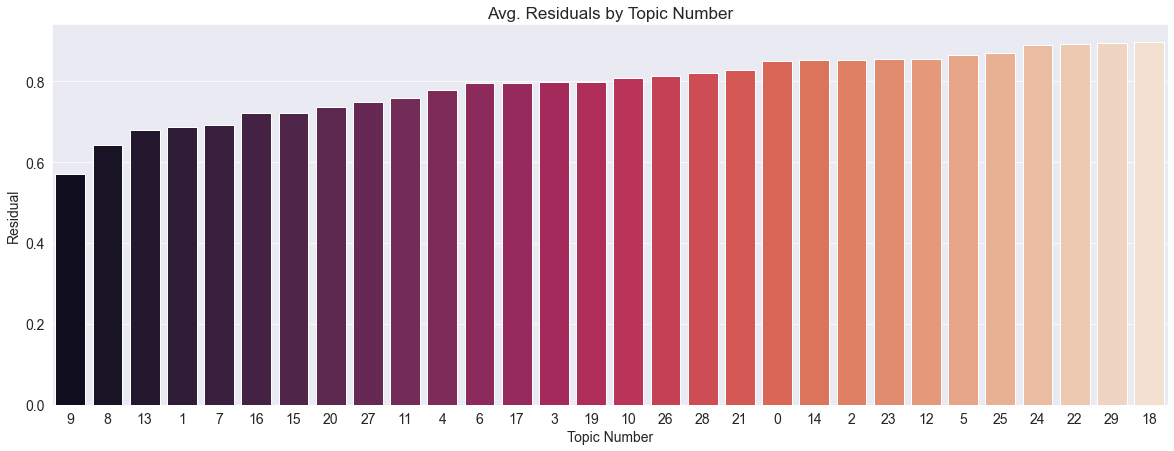

In [64]:
# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = 'avg_resid'

# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

Тема №9 має найнижчий залишок і це означає, що тема найкраще наближає текст, а тема №18 має найвищий залишок.
Опис теми №9: «instacart worker shopper custom order gig compani», і є 5 статей, які належать до цієї теми.

In [67]:
df_topics[df_topics["topic_num"] == 9][["title", "body", "topic_num", "topics", "resid"]]

title  \
88   Workers say gig companies doing 'bare minimum'...   
120  Instacart makes more changes ahead of planned ...   
127  Instacart shoppers plan strike over treatment ...   
134  Here's why Amazon and Instacart workers are st...   
248  Instacart plans to hire 300,000 more workers a...   

                                                  body  topic_num  \
88   Now, some workers say there are inherent contr...          9   
120  Instacart said Sunday that it will soon begin ...          9   
127  The strike is being called for by Instacart sh...          9   
134  Some Instacart workers said they turned off th...          9   
248  The on-demand grocery startup said Monday that...          9   

                                                topics     resid  
88   instacart worker shopper custom order gig compani  0.661251  
120  instacart worker shopper custom order gig compani  0.590937  
127  instacart worker shopper custom order gig compani  0.446796  
134  instacart worker shopper custom order gig compani  0.605131  
248  instacart worker shopper custom order gig compani  0.547899

In [73]:
# df_topics[df_topics["topic_num"] == 9]["url"].values
# df_topics[df_topics["topic_num"] == 9]["title"].values

Посилання на статті:

* [Workers say gig companies doing 'bare minimum' during coronavirus outbreak](https://www.cnn.com/2020/03/16/tech/delivery-workers-coronavirus/index.html)
* [Instacart makes more changes ahead of planned worker strike](https://www.cnn.com/2020/03/29/tech/instacart-strike-hand-sanitizer-tips/index.html)
* [Instacart shoppers plan strike over treatment during pandemic](https://www.cnn.com/2020/03/28/tech/instacart-planned-strike/index.html)
* [Here's why Amazon and Instacart workers are striking at a time when you need them most](https://www.cnn.com/2020/03/30/tech/instacart-amazon-worker-strikes/index.html)
* [Instacart plans to hire 300,000 more workers as demand surges for grocery deliveries](https://www.cnn.com/2020/03/23/tech/instacart-hiring/index.html)

Це дуже когерентна тема, у якій усі статті стосуються працівників Instacart та гіг-економіку. Опис, який ми створили автоматично, досить добре описує цю тему.

Тепер давайте подивимося на найгіршу тему (№ 18). Опис: «egg sell retail price easter product shoe market». Всього в цій темі 16 статей, тому ми зосередимося лише на 5 найкращих з точки зору найвищих залишків.

In [76]:
df_topics[df_topics["topic_num"] == 18].sort_values("resid", ascending=False).head(5)[["title", 
                                                                                       "body", 
                                                                                       "topic_num", 
                                                                                       "topics", 
                                                                                       "resid"]]

title  \
245     Crocs donating its shoes to healthcare workers   
87   Want to buy gold coins or bars? Good luck find...   
61   Rothy's has new idea for ocean plastic waste: ...   
57   Do you really need new clothes every month? Su...   
133     Americans are panic buying food for their pets   

                                                  body  topic_num  \
245  "Over the past week, we have spoken to healthc...         18   
87   But with major gold refineries across Europe s...         18   
61   On Monday, the company announced it is expandi...         18   
57   There's makeup, all kinds of food -- fresh mea...         18   
133  Dog food sales spiked 54% and cat food sales i...         18   

                                               topics     resid  
245  egg sell retail price easter product shoe market  0.968058  
87   egg sell retail price easter product shoe market  0.965073  
61   egg sell retail price easter product shoe market  0.944957  
57   egg sell retail price easter product shoe market  0.943998  
133  egg sell retail price easter product shoe market  0.941757

In [79]:
# df_topics[df_topics["topic_num"] == 18].sort_values("resid", ascending=False).head(5)["url"].values
# df_topics[df_topics["topic_num"] == 18].sort_values("resid", ascending=False).head(5)["title"].values

Посилання на статті:

* [Crocs donating its shoes to healthcare workers](https://www.cnn.com/2020/03/26/business/crocs-donation-coronavirus/index.html)
* [Want to buy gold coins or bars? Good luck finding any](https://www.cnn.com/2020/03/26/investing/gold-demand-supply-coronavirus/index.html)
* [Rothy's has new idea for ocean plastic waste: handbags](https://www.cnn.com/2020/03/02/business/rothys-bags/index.html)
* [Do you really need new clothes every month? Subscription box novelty has worn off](https://www.cnn.com/2020/03/12/business/subscription-box-services-trend/index.html)
* [Americans are panic buying food for their pets](https://www.cnn.com/2020/03/27/business/pet-food-coronavirus-chewy/index.html)

Як бачите, статті розкидані. В основному вони стосуються товарів роздрібної торгівлі та покупок (крім статті про золото), та статті про взуття Crocs, але жодна зі статей не має нічого спільного з пасхою чи яйцями. Вони все ще пов’язані, хоча і досить слабо.

# Прогнозування теми нових статей

Після того, як ви натренуєте tf-idf і NMF моделі, ви можете передати їм нову статтю і передбачити тему. 

In [86]:
# Predicting the topic for an unseen article

# Load the unseen articles for prediction
file_name = '../data/original/unseen_cnn_articles.csv'
df_new = pd.read_csv(file_name)

# Process the text
df_new['processed_text'] = df_new['body'].apply(process_text)
new_texts = df_new['processed_text']

# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]
# Add to the df
df_new['pred_topic_num'] = predicted_topics

df_new

url  \
0  https://www.cnn.com/2020/02/06/tech/nuro-self-...   
1  https://www.cnn.com/2020/04/10/success/managin...   
2  https://www.cnn.com/2020/04/13/economy/unemplo...   
3  https://www.cnn.com/2020/04/06/media/federal-r...   
4  https://www.cnn.com/2020/04/10/tech/nintendo-s...   

                                               title  \
0  US clears the way for this self-driving vehicl...   
1   How to manage a team remotely during this crisis   
2  Congress extended unemployment assistance to g...   
3  Stelter: Federal response to pandemic is a 9/1...   
4  Nintendo pauses Nintendo Switch shipments to J...   

                                                body       date  \
0  Nuro, based in Mountain View, California, is n...  4/11/2020   
1  A deadly pandemic, an economic implosion and a...  4/11/2020   
2  As a freelance copywriter for outdoor, fitness...  4/13/2020   
3  There's a lot of revisionist history being wri...   4/6/2020   
4  The company confirmed to CNN Business that the...  4/12/2020   

                                      processed_text  pred_topic_num  
0  [nuro, base, mountain, view, california, abl, ...              22  
1  [dead, pandem, econom, implos, new, way, work,...               0  
2  [freelanc, copywrit, outdoor, fit, brand, spri...              21  
3  [lot, revisionist, histori, written, right, lo...               3  
4  [compani, confirm, busi, new, shipment, ninten...              17

In [90]:
# df_new["url"].values
# df_new["title"].values

In [91]:
# Join with the original df to get the topic summary
df_new = pd.merge(
    df_new.drop('processed_text', axis=1),
    df_topics[['topic_num', 'topics']],
    left_on='pred_topic_num',
    right_on='topic_num',
    how='inner' 
).drop_duplicates().drop(['topic_num', 'url', 'date'], axis=1)

df_new

title  \
0   US clears the way for this self-driving vehicl...   
11   How to manage a team remotely during this crisis   
19  Congress extended unemployment assistance to g...   
27  Stelter: Federal response to pandemic is a 9/1...   
39  Nintendo pauses Nintendo Switch shipments to J...   

                                                 body  pred_topic_num  \
0   Nuro, based in Mountain View, California, is n...              22   
11  A deadly pandemic, an economic implosion and a...               0   
19  As a freelance copywriter for outdoor, fitness...              21   
27  There's a lot of revisionist history being wri...               3   
39  The company confirmed to CNN Business that the...              17   

                                               topics  
0   solar comput technolog spacex energi power ibm...  
11              work home offic kid desk peopl school  
19     uber worker employ govern self freelanc driver  
27     trump fox news brief hanniti white hous presid  
39        game xbox video play graphic nbc olymp doom

Загалом, модель добре передбачила теми.

* [US clears the way for this self-driving vehicle with no steering wheel or pedals](https://www.cnn.com/2020/02/06/tech/nuro-self-driving-vehicle-houston-dot/index.html)
* [How to manage a team remotely during this crisis](https://www.cnn.com/2020/04/10/success/managing-a-team-remotely-in-a-crisis/index.html)
* [Congress extended unemployment assistance to gig workers. But they're struggling to access it](https://www.cnn.com/2020/04/13/economy/unemployment-gig-workers-challenges/index.html)
* [Stelter: Federal response to pandemic is a 9/11-level failure](https://www.cnn.com/2020/04/06/media/federal-response-coronavirus-reliable-sources/index.html)
* [Nintendo pauses Nintendo Switch shipments to Japan amid global shortage](https://www.cnn.com/2020/04/10/tech/nintendo-switch-shipment-pause-shortage/index.html)

# Використані джерела

* Towards Data Science: [Topic Modeling Articles with NMF](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)
* GitHub: [personal_data_science_projects/topic_modeling_nmf/](https://github.com/robsalgado/personal_data_science_projects/tree/master/topic_modeling_nmf)
* Wiki: [Non-negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)